# Doing this again, only on r1, and extending explicitly rather than implicitly (cuz function is too simple)

In [1]:
# ============================================================
# 0. Imports & global config
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

N_ENT = 400   # number of entities on the circle (you can tweak this)
N_REL = 1    # only one relation R1

torch.manual_seed(0)
np.random.seed(0)


Using device: cuda


In [2]:
import matplotlib as mpl 
mpl.rcParams.update({ "figure.dpi": 500,
                     "savefig.dpi": 500,
                         # Font sizes (COMMONLY USED)
                        "axes.titlesize": 10,              # figure title
                        "axes.labelsize": 9,               # axis labels
                        "xtick.labelsize": 8,
                        "ytick.labelsize": 8,
                        "legend.fontsize": 8,})

In [3]:
# ============================================================
# 1. Dataset: single-step relation R1 on a circle
# ============================================================

class CircleR1Dataset(Dataset):
    """
    Triples (h, r, t) with:
      r = 0 always (only R1)
      t = (h + 1) mod N_ENT
    """
    def __init__(self, N_entities=N_ENT):
        xs = []
        ys = []
        for h in range(N_entities):
            t = (h + 1) % N_entities
            xs.append((h, 0))   # head, rel_id
            ys.append(t)
        self.x = torch.tensor(xs, dtype=torch.long)   # [N, 2]
        self.y = torch.tensor(ys, dtype=torch.long)   # [N]

    def __len__(self):
        return self.x.size(0)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

dataset = CircleR1Dataset()
print("Total triples:", len(dataset))
print("Example triple (x,y):", dataset[0])

Total triples: 400
Example triple (x,y): (tensor([0, 0]), tensor(1))


In [4]:
# ============================================================
# 2. Models: BilinearKG_R1 and ReLUKG_R1
# ============================================================

class BilinearKG_R1(nn.Module):
    """
    Bilinear KG model for a single relation R1.
    heads: entity indices
    rels:  relation index (0 for R1)
    """
    def __init__(self, N_entities=N_ENT, N_relations=N_REL, d=32, m=64):
        super().__init__()
        self.ent_embed = nn.Embedding(N_entities, d)
        self.rel_embed = nn.Embedding(N_relations, d)
        self.W_h = nn.Linear(d, m, bias=False)
        self.W_r = nn.Linear(d, m, bias=False)
        self.out = nn.Linear(m, N_entities, bias=False)

    def forward(self, heads, rels, return_hidden=False):
        e_h = self.ent_embed(heads)   # [B, d]
        e_r = self.rel_embed(rels)    # [B, d]
        u = self.W_h(e_h)             # [B, m]
        v = self.W_r(e_r)             # [B, m]
        h = u * v                     # [B, m]
        logits = self.out(h)          # [B, N_ENT]
        if return_hidden:
            return logits, h
        else:
            return logits


class ReLUKG_R1(nn.Module):
    """
    ReLU baseline KG model for a single relation R1.
    """
    def __init__(self, N_entities=N_ENT, N_relations=N_REL, d=32, m=64):
        super().__init__()
        self.ent_embed = nn.Embedding(N_entities, d)
        self.rel_embed = nn.Embedding(N_relations, d)
        self.fc1 = nn.Linear(2 * d, m)
        self.out = nn.Linear(m, N_entities)

    def forward(self, heads, rels, return_hidden=False):
        e_h = self.ent_embed(heads)   # [B, d]
        e_r = self.rel_embed(rels)    # [B, d]
        x = torch.cat([e_h, e_r], dim=-1)  # [B, 2d]
        h = F.relu(self.fc1(x))       # [B, m]
        logits = self.out(h)          # [B, N_ENT]
        if return_hidden:
            return logits, h
        else:
            return logits

In [5]:
# ============================================================
# 3. Training on full dataset (no validation split)
# ============================================================

def train_full(model, dataset, epochs=400, batch_size=32, lr=1e-3, verbose_every=20):
    model = model.to(device)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    history = {"loss": [], "acc": []}

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        for (x, y) in loader:
            heads, rels = x[:,0].to(device), x[:,1].to(device)
            y = y.to(device)

            logits = model(heads, rels)
            loss = criterion(logits, y)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item() * y.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        epoch_loss = total_loss / len(dataset)
        epoch_acc  = correct / len(dataset)
        history["loss"].append(epoch_loss)
        history["acc"].append(epoch_acc)

        if epoch % verbose_every == 0 or epoch == epochs - 1:
            print(f"[epoch {epoch:3d}] loss={epoch_loss:.4f}, acc={epoch_acc:.3f}")

        if epoch_acc == 1.0:
            print("Early stopping: perfect accuracy.")
            break

    return model, history

bilinear_r1 = BilinearKG_R1(d=32, m=64)
relu_r1     = ReLUKG_R1(d=32, m=64)

print("Training BilinearKG_R1...")
bilinear_r1, hist_b = train_full(bilinear_r1, dataset, epochs=400)

print("\nTraining ReLUKG_R1...")
relu_r1, hist_r = train_full(relu_r1, dataset, epochs=400)


Training BilinearKG_R1...
[epoch   0] loss=5.9998, acc=0.003
Early stopping: perfect accuracy.

Training ReLUKG_R1...
[epoch   0] loss=6.0470, acc=0.000
Early stopping: perfect accuracy.


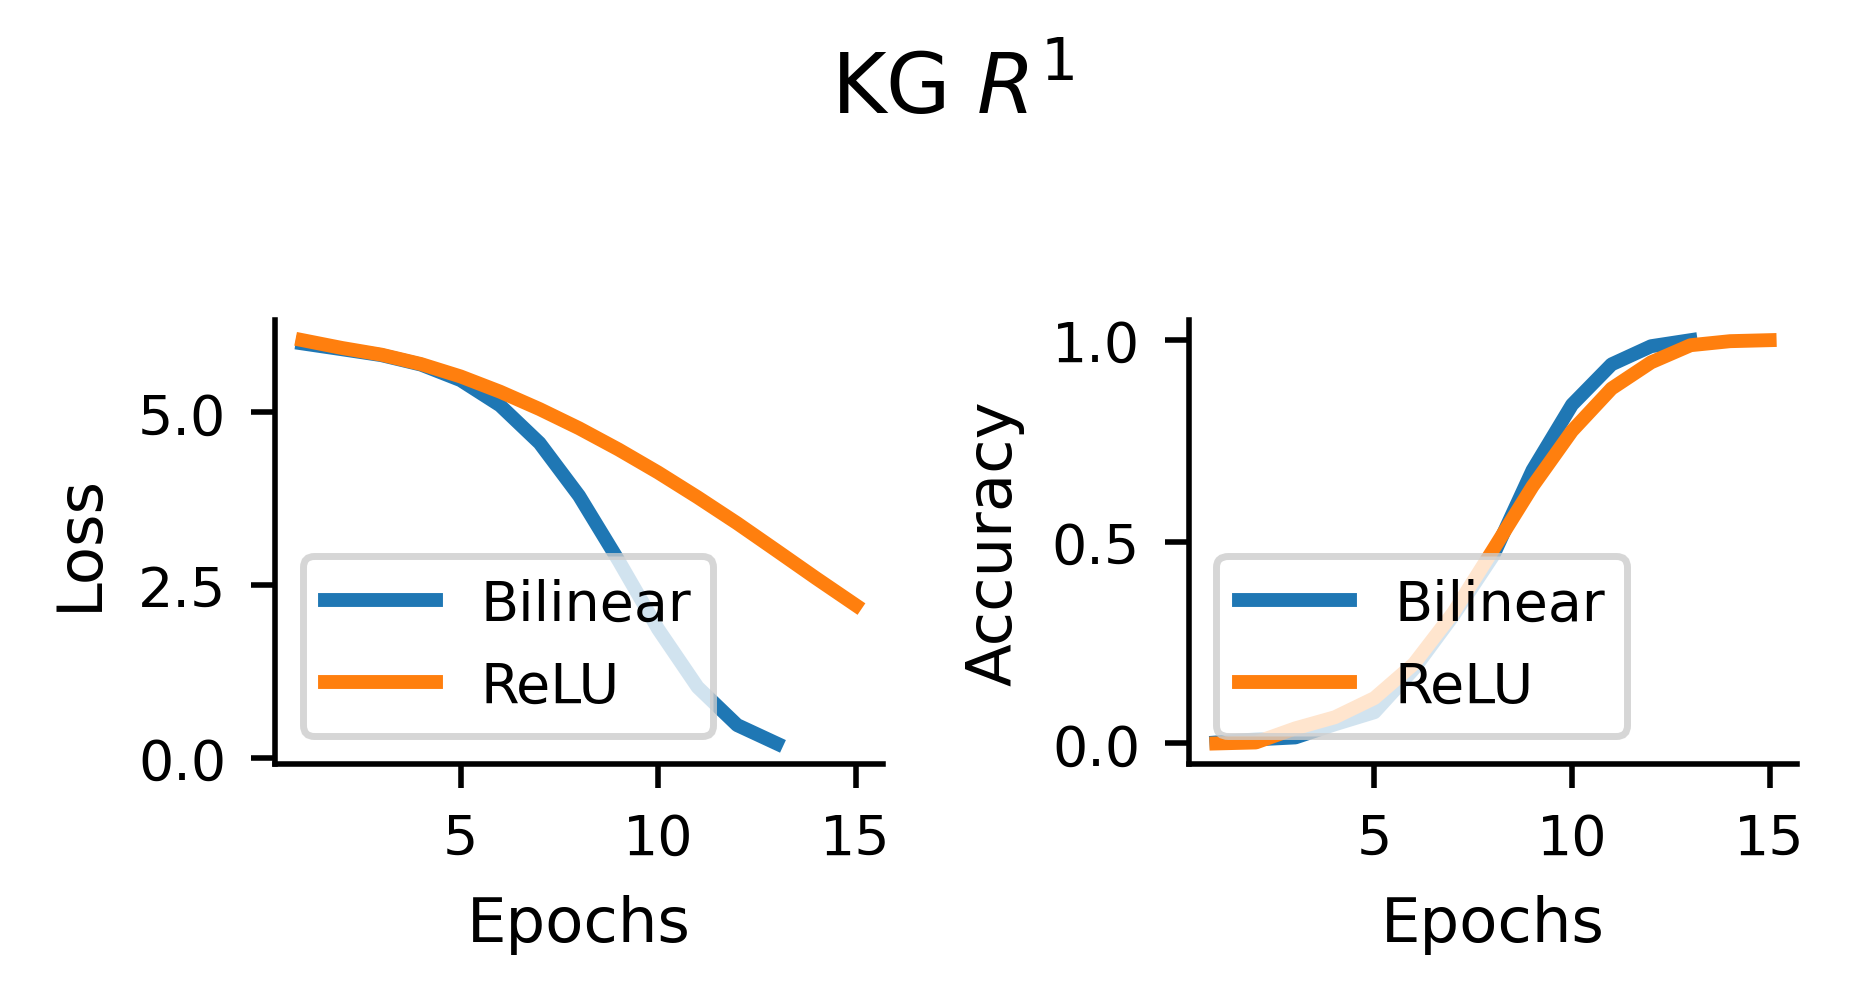

(<Figure size 1850x1000 with 2 Axes>,
 array([<Axes: xlabel='Epochs', ylabel='Loss'>,
        <Axes: xlabel='Epochs', ylabel='Accuracy'>], dtype=object))

In [7]:
import matplotlib.pyplot as plt

def plot_history(history_bil, history_relu, save_path="training_curves.pdf", suptitle="Title"):
    """
    Plot training loss (left) and validation accuracy (right) with a single common title.
    Saves to PDF by default.

    Args:
        history (dict): {"train_loss": [...], "val_acc": [...]}
        save_path (str): path to save figure (should end with .pdf)
        suptitle (str): common title placed above both subplots
    """
    train_loss_bil = history_bil.get("loss", [])
    val_acc_bil = history_bil.get("acc", [])
    train_loss_relu = history_relu.get("loss", [])
    val_acc_relu = history_relu.get("acc", [])
    max_epochs = max(len(train_loss_bil), len(val_acc_bil),
                     len(train_loss_relu), len(val_acc_relu))
    epochs = range(1, max_epochs + 1)

    # Figure (paper-quality)
    fig, axes = plt.subplots(1, 2, figsize=(3.7,2), sharex=True)

    # Left: Training loss
    axes[0].plot(range(1, len(train_loss_bil) + 1), train_loss_bil, linewidth=2, label='Bilinear')
    axes[0].plot(range(1, len(train_loss_relu) + 1), train_loss_relu, linewidth=2, label='ReLU')
    axes[0].legend(loc='lower left')
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    # axes[0].grid(True, linewidth=0.3)
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)

    # Right: Validation accuracy
    axes[1].plot(range(1, len(val_acc_bil) + 1), val_acc_bil, linewidth=2, label='Bilinear')
    axes[1].plot(range(1, len(val_acc_relu) + 1), val_acc_relu, linewidth=2, label='ReLU')
    axes[1].legend(loc='lower left')
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    # axes[1].grid(True, linewidth=0.3)
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)

    # Single common title
    fig.suptitle(suptitle)
    plt.tight_layout(rect=[0, 0, 1, 0.94])  # make room for suptitle

    # Save as PDF (vector)
    if save_path:
        if not save_path.lower().endswith(".pdf"):
            raise ValueError("save_path should end with .pdf for PDF saving.")
        plt.savefig(save_path, format="pdf", bbox_inches="tight")

    plt.show()
    return fig, axes


plot_history(hist_b, hist_r, "/kaggle/working/kgr1.pdf", suptitle=r"KG $R^1$")

In [8]:
# ============================================================
# 5. Extract learned operator T_R1 from each model
# ============================================================

def get_T_R1(model, use_softmax=True):
    """
    Returns T: [N_ENT, N_ENT] where column h = p(tail | head=h).
    """
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        heads = torch.arange(N_ENT, device=device, dtype=torch.long)
        rels  = torch.zeros_like(heads)  # all R1
        logits = model(heads, rels)      # [N, N]
        if use_softmax:
            probs = F.softmax(logits, dim=1)   # [N_heads, N_tails]
        else:
            probs = logits
        T = probs.T.cpu().numpy()        # [tail, head]
    return T

T_b = get_T_R1(bilinear_r1, use_softmax=True)
T_r = get_T_R1(relu_r1, use_softmax=True)

print("T_b shape:", T_b.shape)
print("T_r shape:", T_r.shape)


T_b shape: (400, 400)
T_r shape: (400, 400)


Mean column entropy (bilinear): 0.7383404 +/- 0.5706049
Mean column entropy (relu):     4.8869376 +/- 0.51073223


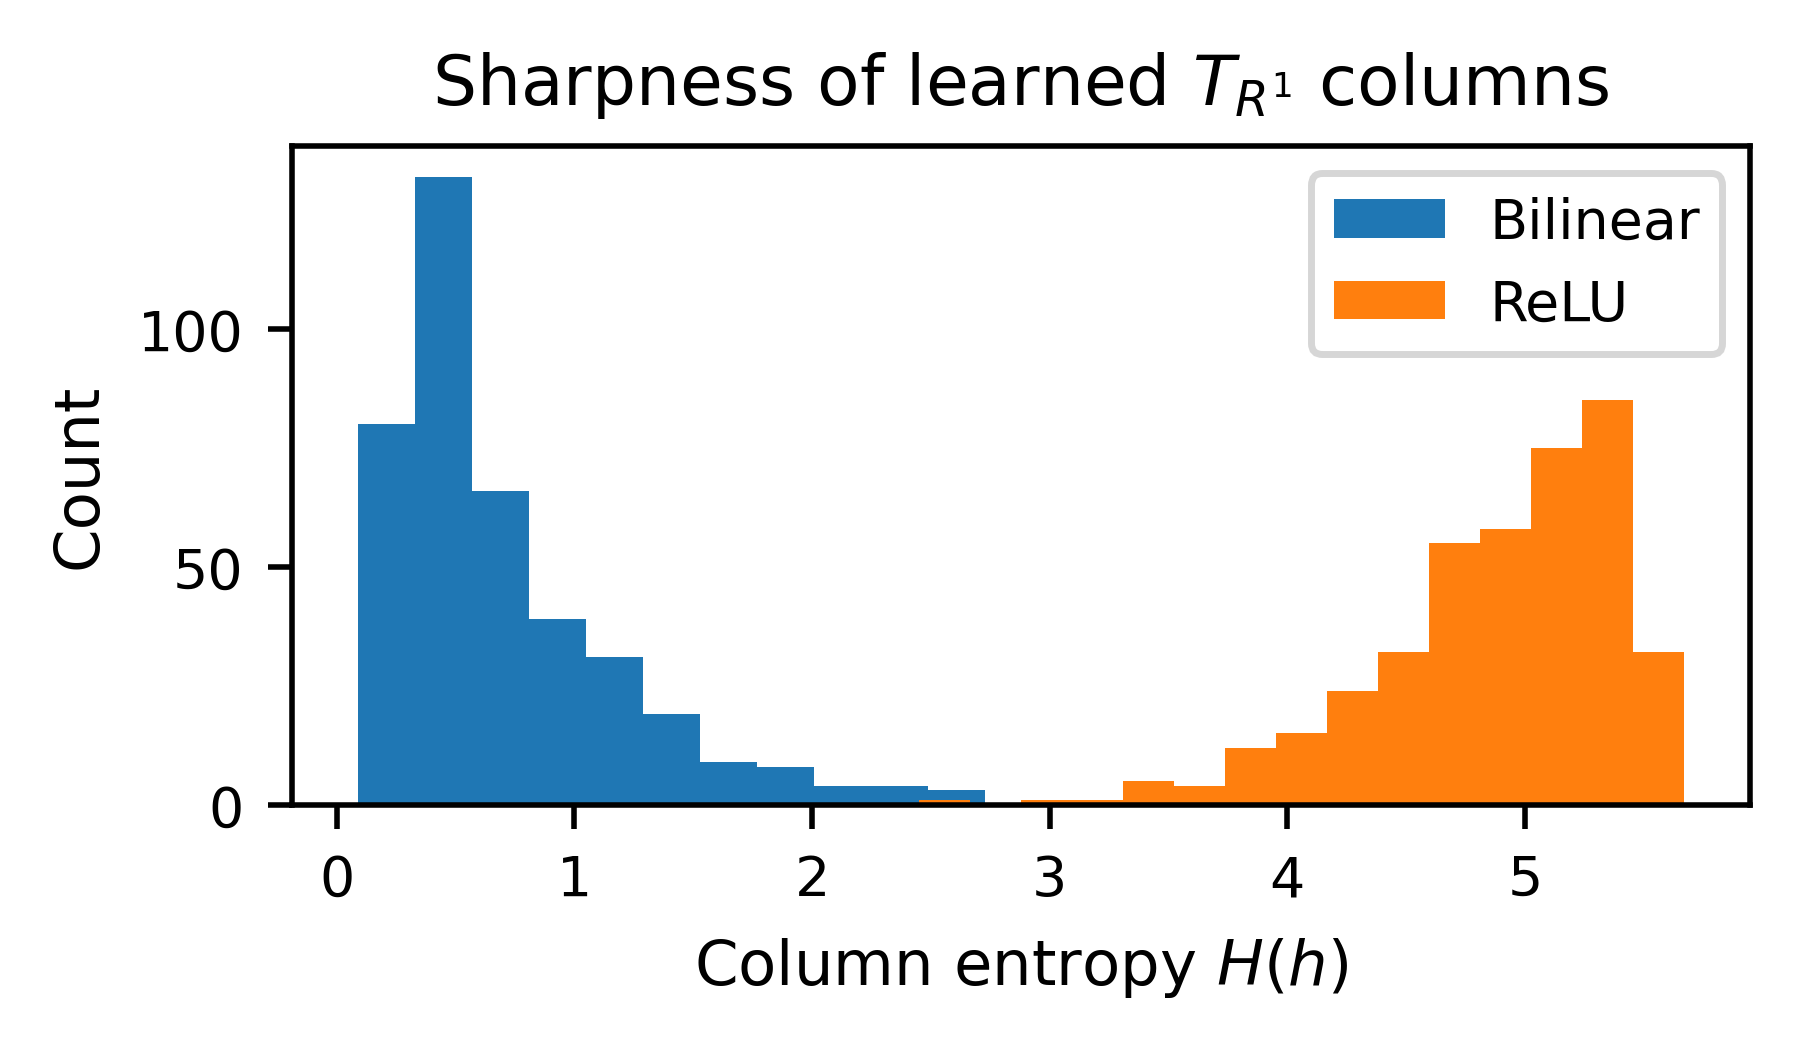

In [9]:
# ============================================================
# 6. Column entropy: how sharp are the learned columns?
# ============================================================

def column_entropy(T):
    """
    T: [N, N], column h = distribution over tails.
    Returns array of entropies H(h).
    """
    eps = 1e-12
    ent = []
    for h in range(T.shape[1]):
        p = T[:,h]
        p = np.clip(p, eps, 1.0)
        p = p / p.sum()
        H = -np.sum(p * np.log(p))
        ent.append(H)
    return np.array(ent)

H_b = column_entropy(T_b)
H_r = column_entropy(T_r)

print("Mean column entropy (bilinear):", H_b.mean(), "+/-", H_b.std())
print("Mean column entropy (relu):    ", H_r.mean(), "+/-", H_r.std())

plt.figure(figsize=(3.7,2.2))
plt.hist(H_b, bins=15, alpha=1, label="Bilinear")
plt.hist(H_r, bins=15, alpha=1, label="ReLU")
plt.xlabel(r"Column entropy $H(h)$")
plt.ylabel("Count")
plt.title(r"Sharpness of learned $T_{R^1}$ columns")
plt.legend()
plt.tight_layout()
plt.savefig('/kaggle/working/sharpness', format="pdf", bbox_inches="tight")
plt.show()


Bilinear multi-step accuracies: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9975, 0.995, 0.9925, 0.9925, 0.9925, 0.9875, 0.9825, 0.97, 0.9675, 0.9625, 0.95, 0.945, 0.9375, 0.91, 0.8775, 0.855, 0.82, 0.7675, 0.715, 0.67, 0.62, 0.5575, 0.5025, 0.4575, 0.405, 0.36, 0.3225, 0.29, 0.265, 0.2425, 0.225, 0.205, 0.185, 0.165, 0.1525, 0.1375, 0.12, 0.105, 0.0975, 0.08, 0.0575, 0.0425, 0.0325, 0.025, 0.02, 0.0125, 0.01, 0.01, 0.0075, 0.005, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025]
ReLU     multi-step accuracies: [1.0, 0.895, 0.59, 0.1075, 0.0075, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 

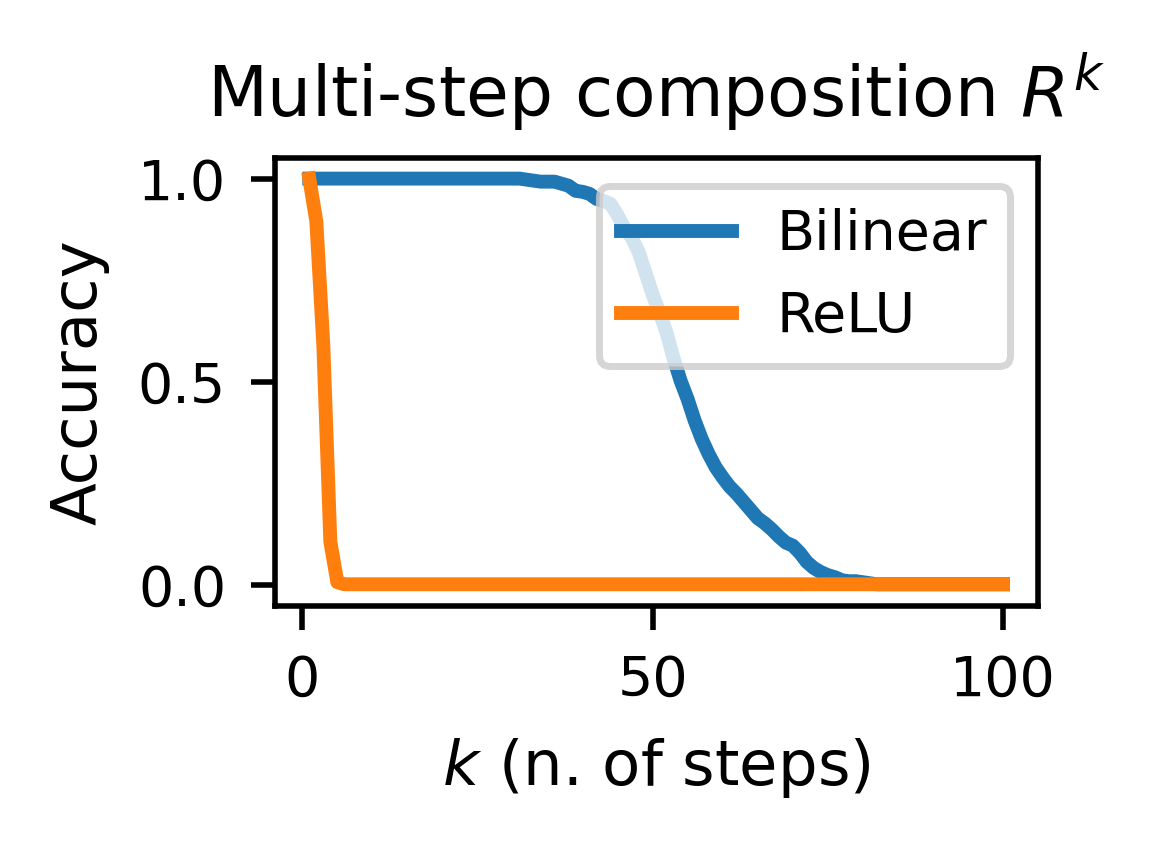

In [10]:
# ============================================================
# 7. Multi-step accuracy via T^k
# ============================================================

def multi_step_accuracy(T, max_k=1000, device = "cuda"):
    """
    T: [N_ENT, N_ENT], column-stochastic (p(tail|head)).
    Returns list of accuracies for k = 1..max_k.
    True relation is R1: t = (h + 1) mod N_ENT.
    So k-step true tail = (h + k) mod N_ENT.
    """
    N = T.shape[0]
    T = torch.tensor(T, dtype = torch.float32, device = device)
    accs = []
    T_power = torch.eye(N, device = device)   # start with identity
    for k in range(1, max_k+1):
        T_power = T @ T_power  # T_power = T^k
        correct = 0
        total = N
        for h in range(N):
            # predicted distribution after k steps from head h:
            # column h of T_power
            col = T_power[:, h]
            pred_tail = int(col.argmax())
            true_tail = (h + k) % N  # ground truth for R1^k
            if pred_tail == true_tail:
                correct += 1
        accs.append(correct / total)
    return accs

max_k = 100
accs_b = multi_step_accuracy(T_b, max_k=max_k)
accs_r = multi_step_accuracy(T_r, max_k=max_k)

print("Bilinear multi-step accuracies:", accs_b)
print("ReLU     multi-step accuracies:", accs_r)

plt.figure(figsize=(2.3, 1.8))
ks = np.arange(1, max_k+1)
plt.plot(ks, accs_b, marker=None, label="Bilinear", linewidth=2)
plt.plot(ks, accs_r, marker=None, label="ReLU", linewidth=2)
plt.xlabel(r"$k$ (n. of steps)")
plt.ylabel(r"Accuracy")
plt.title(r"Multi-step composition $R^k$")
plt.ylim(-0.05, 1.05)
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig('/kaggle/working/multistep', format="pdf", bbox_inches="tight")
plt.show()
